In [12]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import NV
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [13]:
def T1Fit(t,I_inf,C_m,T_m,C_1,T_1):
         return I_inf * (1 - C_m*np.exp(-t/T_m) + C_1*np.exp(-t/T_1))

[   6.59601972   62.55667146  484.5272618    70.55131189  751.46405476]


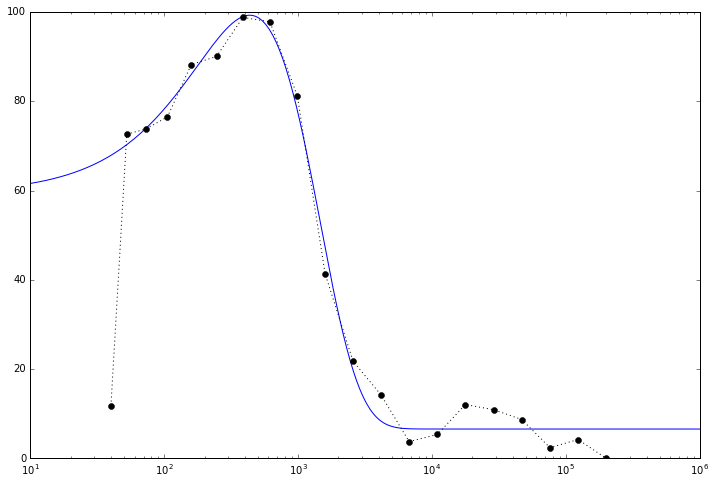

In [14]:
time,T0 = NV.EPR(r'C:\Users\Ouyang Group\Documents\Data\8-27-16\MNP on CPW 5mW scan 3 T1 x53 y72 T1 7200 sec *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\8-27-16\MNP on CPW 5mW scan 3 T1 x53 y72 T1 7200 sec  Pulse Seq')
time = time+20
T0 = T0 - np.min(T0)
opt0,cov0 = curve_fit(T1Fit,time[1:],T0[1:],maxfev=5500,p0=(0,0.1,200,0.2,1000))
t = np.logspace(1,6,200)
plt.semilogx(t,T1Fit(t,*opt0),'b-')
print opt0
plt.semilogx(time,T0,'ko:')

[  11.36681519   18.43501695  309.73732582   22.3373244   677.54654368]


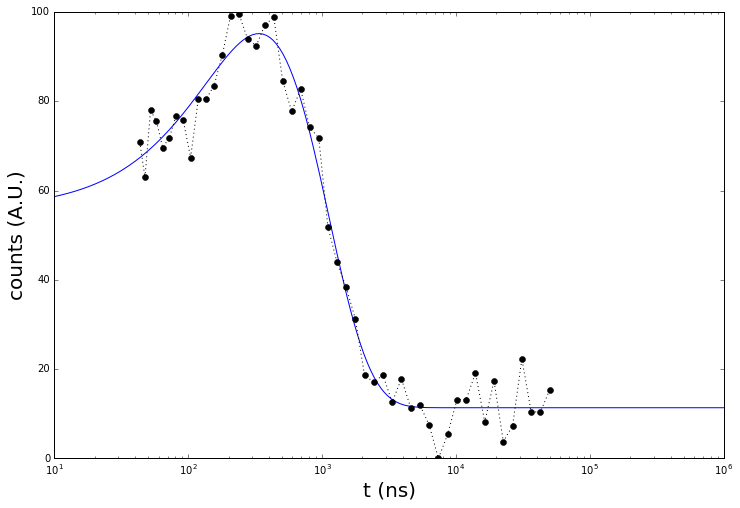

In [308]:
time,T0 = NV.EPR(r'C:\Users\Ouyang Group\Documents\Data\8-30-16\MNP on CPW 5mW scan 2 x48 y70 T1 *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\8-30-16\MNP on CPW 5mW scan 2 x48 y70 T1 Pulse Seq.txt')
time = time+20
T0 = T0 - np.min(T0)
opt0,cov0 = curve_fit(T1Fit,time[1:],T0[1:],maxfev=5500,p0=(0,0.1,200,0.2,1000))
t = np.logspace(1,6,200)
plt.semilogx(t,T1Fit(t,*opt0),'b-')
print opt0
plt.semilogx(time[1:],T0[1:],'ko:')
plt.xlabel('t (ns)',fontsize=20)
plt.ylabel('counts (A.U.)',fontsize=20)

12.4954982007
28.1404278673


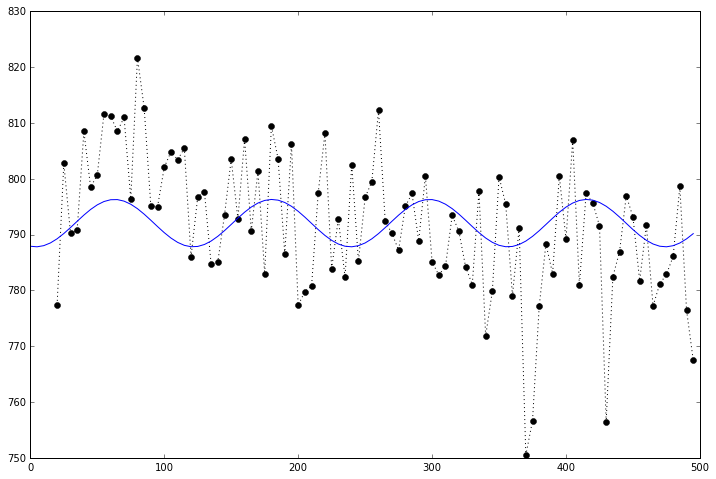

In [133]:
time,rabi0 = NV.EPR_NoRef(r'C:\Users\Ouyang Group\Documents\Data\8-31-16\MNP on CPW 5mW scan 2 T-23 d3.9 2 x35 y94 B0.2V Rabi *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\8-31-16\MNP on CPW 5mW scan 2 T-23 d3.9 2 x35 y94 B0.2V Rabi Pulse Seq.txt')
rabi0 = rabi0
opt0,cov0 = curve_fit(NV.RabiFit,time[1:],rabi0[1:],maxfev=2500,p0=(6,8E-3,0,2000,-3))
plt.plot(time,rabi0,'ko:')
t = np.arange(0,500,5)
plt.plot(t,NV.RabiFit(t,*opt0),'b-')
#print opt0
print np.std(rabi0)
print np.sqrt(np.mean(rabi0))

Phi: -37.653464 +/- 0.282526
Theta: 61.697779 or +/- 0.355633
Phi(naive): -29.326000
Theta(naive): 64.031615


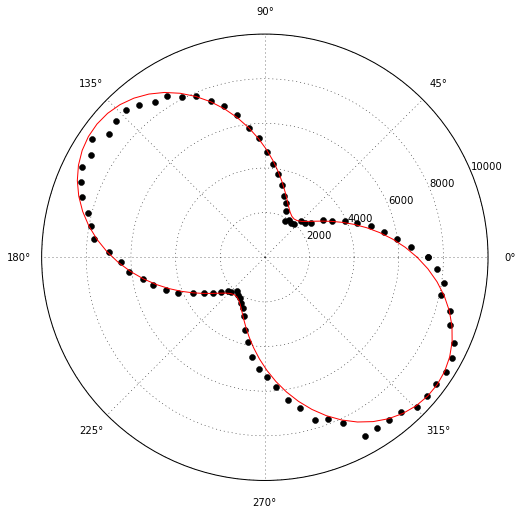

In [6]:
t = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\8-30-16\MNP on CPW 0.5mW scan 2 x48 y70 rotor sweep')
t[:,1] = t[:,1]-780
NV.OrientPol(t)

In [134]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh import palettes
output_notebook()
TOOLS = "save,box_zoom,box_select,crosshair,hover,resize,reset"
import pandas as pd
import glob

files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\8-30-16\MNP on CPW 0.5mW scan 2 x48 y70  T-23 d3.9 2 ODMR *V.txt')
output_file("8-30-16 MNP x48 y70 T138.8  d_5.3 ODMR.html")
bsweep = pd.concat((pd.read_table(f) for f in files),axis=1).values
bsweep = np.nan_to_num(bsweep)
diffs = bsweep[:,1::3]
Bs = np.linspace(0,2,len(files))*(11/0.5)
p = figure(x_range=[Bs[0],Bs[-1]], y_range=[bsweep[4,0],bsweep[-2,0]],tools=TOOLS)
p.image(image=[diffs],x=Bs[0], y=bsweep[4,0], dw=[Bs[-1]], dh=[bsweep[-2,0]-bsweep[4,0]], palette='RdPu9')
p.line(Bs,2.865E9+Bs*28E6,line_dash=(6,6),line_color='black')
p.line(Bs,2.865E9-Bs*28E6,line_dash=(6,6),line_color='black')
show(p)

Loading BokehJS ...

In [239]:
freq = bsweep[:,0]
fits = np.zeros((diffs.shape[1],6))
for i in range(0,diffs.shape[1]):
    O = diffs[:,i]*1000
    opt, cov = curve_fit(NV.ODMRfit,freq,O,p0=(-4E8,freq[np.argmin(O)],1E7,-4E8,2.85E9*2-freq[np.argmin(O)],1E7),maxfev=2500)
    fits[i,:] = opt
    
mask = (fits[:,1]<fits[:,4])
mins = fits[:,1]*mask + fits[:,4]*~mask
maxs = fits[:,1]*~mask + fits[:,4]*mask


theta = 2
opt1, cov = curve_fit(NV.ODMR_theory_min,Bs[2:9],mins[2:9],p0=(theta))
print "%2f +/- %2f" % (opt1*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)
opt2, cov = curve_fit(NV.ODMR_theory_max,Bs[2:10],maxs[2:10],p0=(theta))
print "%2f +/- %2f" % (opt2*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)

#plt.plot(Bs[1:-3],mins[1:-3],'ko')
plt.plot(Bs[1:-3],maxs[1:-3],'ko')


#plt.plot(Bs,NV.ODMR_theory_min(Bs,opt1),'k:')
plt.plot(Bs,NV.ODMR_theory_max(Bs,opt2),'k:')
print fits

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2500.

In [158]:
B_new = np.linspace(0,2,20)
f_p = 2.865E9+B_new*(11/0.5)*28E6
np.savetxt(r'C:\Users\Ouyang Group\Documents\Data\9-1-16\MNP on CPW 5mW scan 2 T-23 d3.9 upper res.txt',
           np.column_stack((B_new,f_p)),fmt='%f',delimiter='\t')

f_p = 2.865E9-B_new*(11/0.5)*28E6
np.savetxt(r'C:\Users\Ouyang Group\Documents\Data\9-1-16\MNP on CPW 5mW scan 2 T-23 d3.9 lower res.txt',
           np.column_stack((B_new,f_p)),fmt='%f',delimiter='\t')

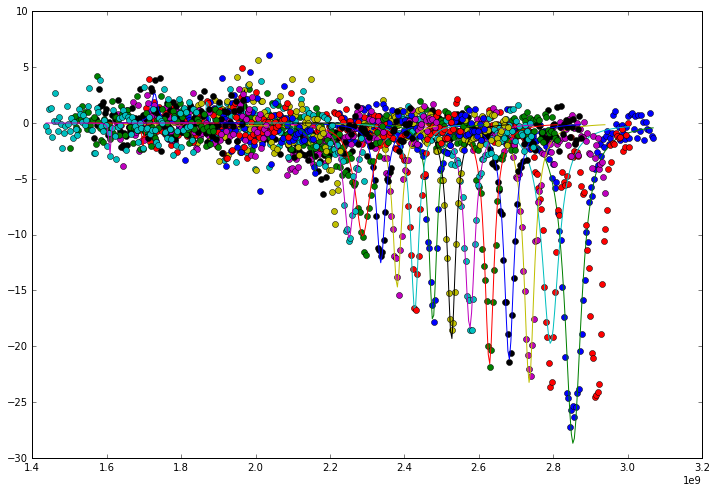

In [246]:
import re
def lorentzian_2(X,a,x0,c):
    return a*c**2/(np.pi*c*(c**2+(X-x0)**2))

files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\9-1-16\MNP on CPW 5mW scan 2 T-23 d3.9 local lower ODMR [0-9].*V ODMR')
res = np.zeros((len(files),3))
reg = re.compile(r'(\d\.\d+) V')
for i,f in enumerate(files):
    o = np.loadtxt(f)
    m = re.search(reg,f)
    opt,cov = curve_fit(NV.lorentzian_2,o[1:,0],o[1:,1],p0=(-4E8,2.85E9-28E6*float(m.group(1))*11/0.5,1E7),maxfev=5500)
    res[i,0]=m.group(1)
    res[i,1]=opt[1]
    res[i,2]=np.sqrt(np.diag(cov))[1]
    plt.plot(o[1:,0],o[1:,1],'o')
    plt.plot(o[1:,0],lorentzian_2(o[1:,0],*opt))
    
mins = res

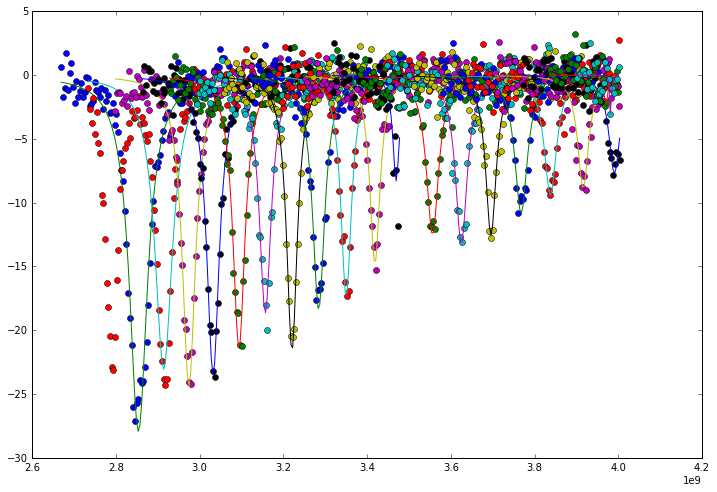

In [247]:
import re
def lorentzian_2(X,a,x0,c):
    return a*c**2/(np.pi*c*(c**2+(X-x0)**2))

files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\9-1-16\MNP on CPW 5mW scan 2 T-23 d3.9 local upper ODMR [0-9].*V ODMR')
res = np.zeros((len(files),3))
reg = re.compile(r'(\d\.\d+) V')
for i,f in enumerate(files):
    o = np.loadtxt(f)
    m = re.search(reg,f)
    opt,cov = curve_fit(NV.lorentzian_2,o[1:,0],o[1:,1],p0=(-4E8,2.865E9+28E6*float(m.group(1))*11/0.5,1E7),maxfev=5500)
    res[i,0]=m.group(1)
    res[i,1]=opt[1]
    res[i,2]=np.sqrt(np.diag(cov))[1]
    plt.plot(o[1:,0],o[1:,1],'o')
    plt.plot(o[1:,0],lorentzian_2(o[1:,0],*opt))
    
maxs = res

In [254]:
maxs

array([[  0.00000000e+00,   2.85354762e+09,   5.54087256e+05],
       [  1.05263000e-01,   2.91386851e+09,   2.89325830e+06],
       [  2.10526000e-01,   2.97420778e+09,   3.85471830e+05],
       [  3.15789000e-01,   3.03195959e+09,   4.15367866e+05],
       [  4.21053000e-01,   3.09381093e+09,   5.11902263e+05],
       [  5.26316000e-01,   3.15663719e+09,   5.36020965e+05],
       [  6.31579000e-01,   3.22040674e+09,   4.07381294e+05],
       [  7.36842000e-01,   3.28419890e+09,   5.17273966e+05],
       [  8.42105000e-01,   3.34994018e+09,   5.24258973e+05],
       [  9.47368000e-01,   3.41863523e+09,   5.76510263e+05],
       [  1.05263200e+00,   3.46937642e+09,   1.54984147e+06],
       [  1.15789500e+00,   3.55629936e+09,   8.09650314e+05],
       [  1.26315800e+00,   3.62509022e+09,   8.17651066e+05],
       [  1.36842100e+00,   3.69592117e+09,   7.60077508e+05],
       [  1.47368400e+00,   3.76802161e+09,   8.26993642e+05],
       [  1.57894700e+00,   3.83794268e+09,   1.0314578

28.147617 +/- 0.256180
24.346839 +/- 1.837333


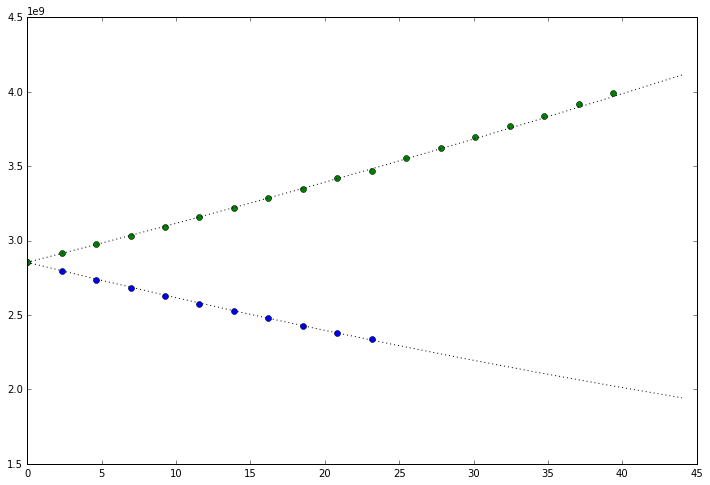

In [263]:
def ODMR_theory_min(B,theta):
    D = 2.854E9
    g = 28E6 #MHz/mT, B should be in mT
    
    f_0 = D + 3*g**2*B**2/(2*D)*np.sin(theta)**2
    f_1 = g*B*np.cos(theta)*np.sqrt( 1 + (g*B/(2*D)*np.tan(theta)*np.sin(theta))**2)
    
    return f_0-f_1

def ODMR_theory_max(B,theta):
    D = 2.854E9
    g = 28E6 #MHz/mT, B should be in mT
    
    f_0 = D + 3*g**2*B**2/(2*D)*np.sin(theta)**2
    f_1 = g*B*np.cos(theta)*np.sqrt( 1 + (g*B/(2*D)*np.tan(theta)*np.sin(theta))**2)
    
    return f_0+f_1

B_min = mins[:11,0]*11/0.5
B_max = maxs[:-2,0]*11/0.5
plt.errorbar(B_min,mins[:11,1],yerr=mins[:11,2],marker='o',ls='none')
plt.errorbar(B_max,maxs[:-2,1],yerr=maxs[:-2,2],marker='o',ls='none')

theta = 4*np.pi/180
opt1, cov = curve_fit(ODMR_theory_min,B_min,mins[:11,1],p0=(theta))
print "%2f +/- %2f" % (opt1*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)
opt2, cov = curve_fit(ODMR_theory_max,B_max,maxs[:-2,1],p0=(theta))
print "%2f +/- %2f" % (opt2*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)



plt.plot(Bs,ODMR_theory_min(Bs,opt1),'k:')
plt.plot(Bs,ODMR_theory_max(Bs,opt2),'k:')

In [202]:
maxs[0,1]

2853547615.1721106

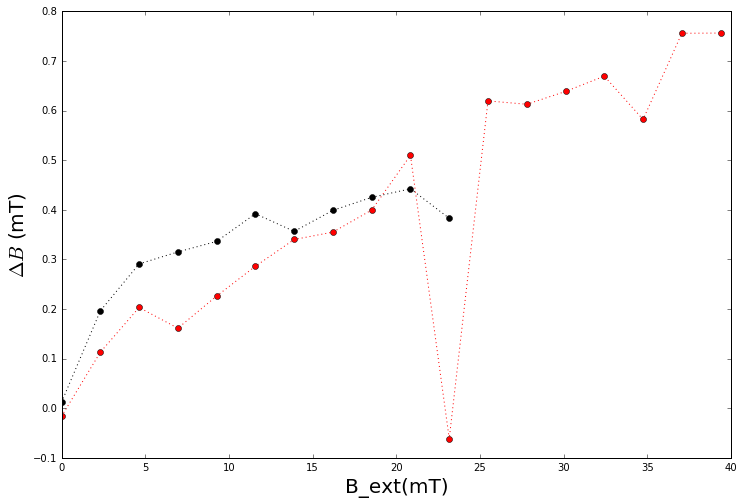

In [312]:
def plot_diff(t):
    plt.plot(B_min,(ODMR_theory_min(B_min,t*np.pi/180)-mins[:11,1])/(28E6),'ko:')
    plt.plot(B_max,(maxs[:-2,1]-ODMR_theory_max(B_max,t*np.pi/180))/(28E6),'ro:')
    #plt.errorbar(B_min,(mins[:11,1]-ODMR_theory_min(B_min,27*np.pi/180))/(28E6),yerr=mins[:11,2]/28E6,marker='o',ls='none')
    #plt.errorbar(B_max,(maxs[:-2,1]-ODMR_theory_max(B_max,27*np.pi/180))/(28E6),yerr=maxs[:-2,2]/28E6,marker='o',ls='none')
    g = 5567 #mT at 1nm from 3.5nm radius Fe3O4
    plt.xlabel('B_ext(mT)',fontsize=20)
    plt.ylabel('$\Delta B$ (mT)',fontsize=20)
    
from ipywidgets import widgets
widgets.interact(plot_diff,t=(0,30,0.2))

In [127]:
-

In [282]:
f

array([[  0.00000000e+00,   1.11948659e+01,   2.16384981e+01,
          2.75102893e+02,   2.38554236e+01,   6.20096169e+02,
          1.97614400e+00,   2.00017155e+01,   1.27081929e+02,
          2.03440010e+01,   2.25224883e+02],
       [  1.05263000e-01,   1.74924026e+01,   1.14818653e+01,
          2.74554936e+02,   1.28282679e+01,   6.11942481e+02,
          2.39031145e+00,   1.64302323e+01,   1.90109082e+02,
          1.66816169e+01,   3.29146077e+02],
       [  2.10526000e-01,   1.47585456e+01,   1.04559174e+01,
          2.28644751e+02,   1.16688316e+01,   7.54616614e+02,
          1.63771366e+00,   3.84332778e+00,   7.21377029e+01,
          4.09187874e+00,   1.72492415e+02],
       [  3.15789000e-01,   3.02430271e+01,   5.64023499e+02,
          4.11557847e+02,   5.64602403e+02,   4.15584658e+02,
          1.76786573e+00,   3.85068783e+06,   1.36910663e+04,
          3.85068794e+06,   1.37870696e+04],
       [  4.21053000e-01,   3.88923274e+01,   3.52451650e+00,
          1.99

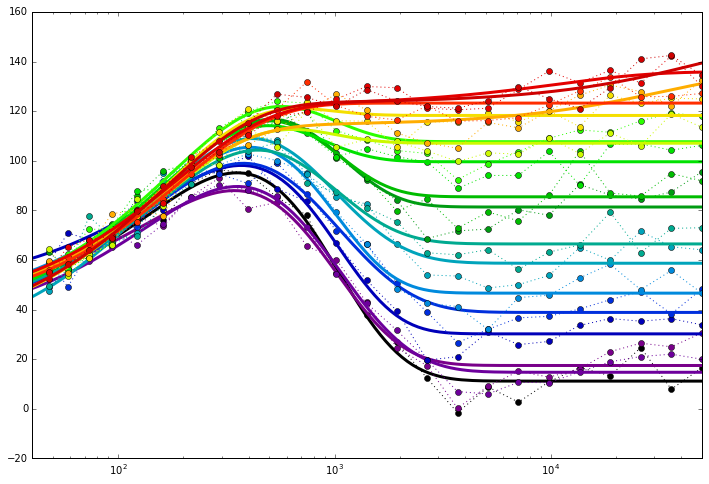

In [270]:
f = BatchT1(r'C:\Users\Ouyang Group\Documents\Data\8-30-16\MNP on CPW 5mW scan 2 T-23 d3.9 2 T1 ')

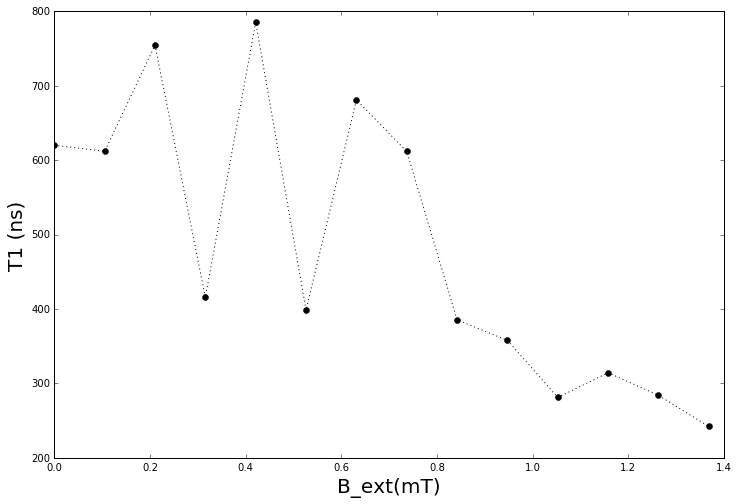

In [296]:
plt.plot(f[:-4,0],f[:-4,5],'ko:')
plt.xlabel('B_ext(mT)',fontsize=20)
plt.ylabel('T1 (ns)',fontsize=20)

C:\Users\Ouyang Group\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: invalid value encountered in sqrt


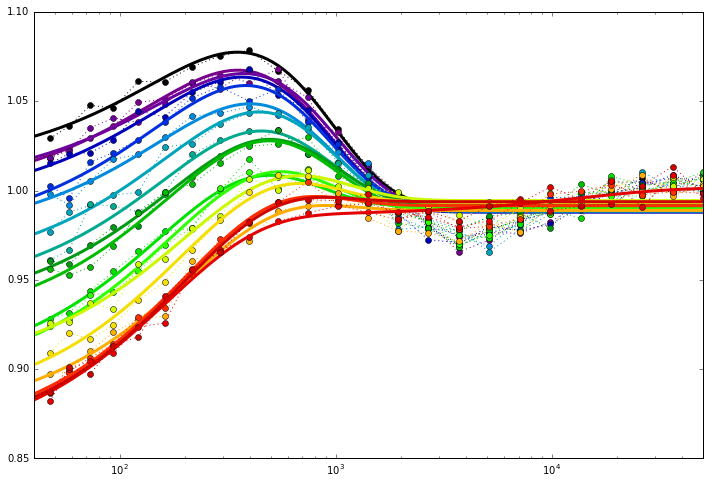

In [119]:
f = BatchT1(r'C:\Users\Ouyang Group\Documents\Data\8-30-16\MNP on CPW 5mW scan 2 T-23 d3.9 2 T1 ')


In [269]:
plt.plot(f[:-2,0],f[:-2,5])

TypeError: string indices must be integers, not tuple

[ 646.57897048   10.17886356  266.74452453   10.05132875  269.29142481]


C:\Users\Ouyang Group\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


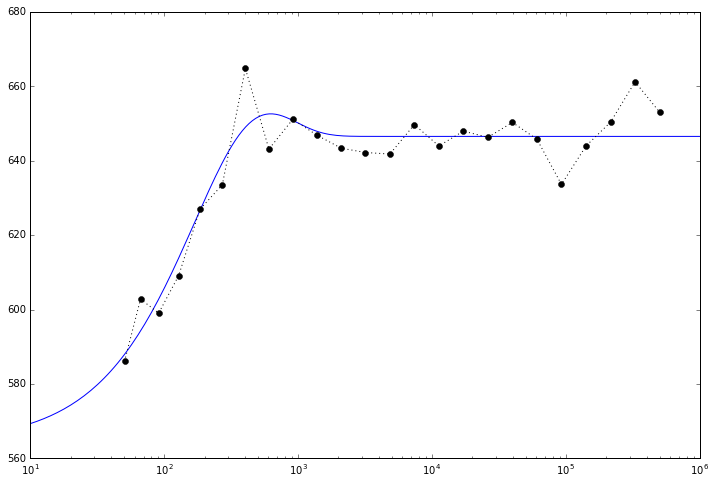

In [98]:
time,T0 = NV.EPR_NoRef(r'C:\Users\Ouyang Group\Documents\Data\8-31-16\MNP on CPW 5mW scan 2 T-23 d3.9 2 T1 x34 y87 3600 sec 1.333333 V  *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\8-31-16\MNP on CPW 5mW scan 2 T-23 d3.9 2 T1 x34 y87 3600 sec 1.333333 V   Pulse Seq')
time = time+20
T0 = T0# - np.min(T0)
opt0,cov0 = curve_fit(T1Fit,time[1:],T0[1:],maxfev=5500,p0=(0,0.1,200,0.2,1000))
t = np.logspace(1,6,200)
plt.semilogx(t,T1Fit(t,*opt0),'b-')
print opt0
plt.semilogx(time[1:],T0[1:],'ko:')